In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG19

In [2]:
tf.__version__

'2.6.4'

# **Visualizing Classes**

In [3]:
train_dir = '../input/apple-disease-dataset/datasets/train/'
test_dir = '../input/apple-disease-dataset/datasets/test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [4]:
pd.concat([Train_Count,Test_Count] , axis=1)

Train  Test
apple_scab         2016   504
healthy            2008   502
black_rot          1987   497
cedar_apple_rust   1760   440

<AxesSubplot:>

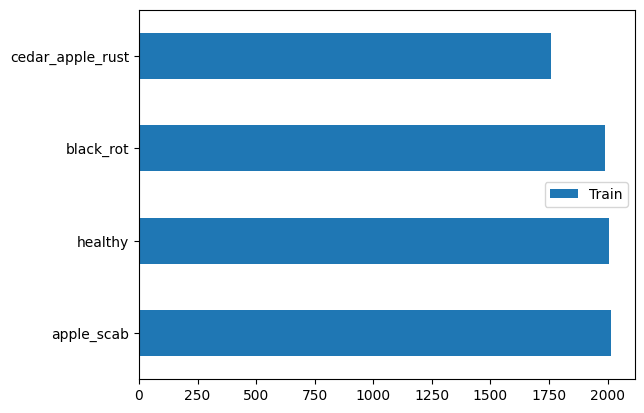

In [5]:
Train_Count.plot(kind='barh')

<AxesSubplot:>

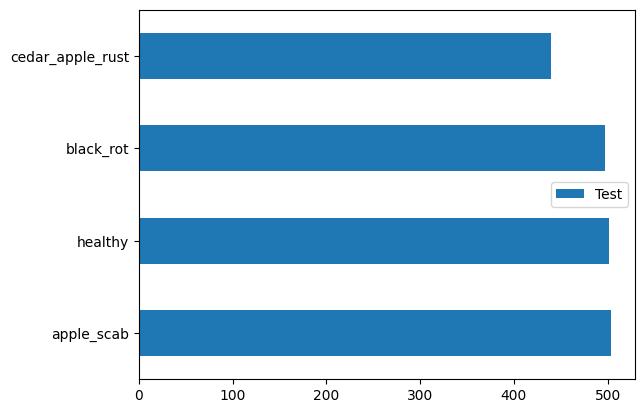

In [6]:
Test_Count.plot(kind='barh')

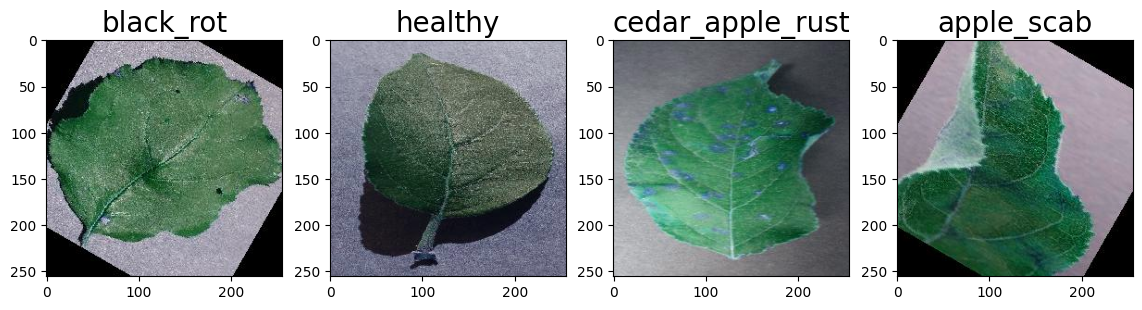

In [7]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL = '../input/apple-disease-dataset/datasets/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

# **Data Preprocessing**

In [8]:
img_shape = 224
batch_size = 64
train_data_path = '../input/apple-disease-dataset/datasets/train/'
test_data_path = '../input/apple-disease-dataset/datasets/test/'

In [9]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 7771 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# **VGG19 Model**

In [10]:
VGG19 = tf.keras.applications.VGG19(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

VGG19.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [11]:
# Freezing all layers except last 50

VGG19.trainable = True

for layer in VGG19.layers[:-50]:
    layer.trainable = False

In [12]:
def Create_VGG19_Model():

    model = Sequential([
                      VGG19,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(4,activation='softmax')
                    ])
    return model

In [13]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score

precision = Precision()
recall = Recall()

In [14]:
VGG19_Model = Create_VGG19_Model()

VGG19_Model.summary()

VGG19_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

**Specifying Callbacks**

In [15]:
# Create Callback Checkpoint
checkpoint_path = "VGG19_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [16]:
VGG19_history = VGG19_Model.fit(train_data ,validation_data = test_data , epochs=60, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/60
121/121 [==============================] - 175s 1s/step - loss: 1.0214 - accuracy: 0.5984 - precision: 0.6456 - recall: 0.5191 - val_loss: 1.0164 - val_accuracy: 0.6839 - val_precision: 0.6953 - val_recall: 0.6714
Epoch 2/60
121/121 [==============================] - 122s 1s/step - loss: 0.6281 - accuracy: 0.7484 - precision: 0.7808 - recall: 0.7007 - val_loss: 3.8134 - val_accuracy: 0.2536 - val_precision: 0.2635 - val_recall: 0.2516
Epoch 3/60
121/121 [==============================] - 120s 987ms/step - loss: 0.4547 - accuracy: 0.8270 - precision: 0.8448 - recall: 0.7950 - val_loss: 1.0673 - val_accuracy: 0.6672 - val_precision: 0.6762 - val_recall: 0.6547

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/60
121/121 [==============================] - 120s 982ms/step - loss: 0.3288 - accuracy: 0.8824 - precision: 0.8984 - recall: 0.8661 - val_loss: 1.5493 - val_accuracy: 0.3865 - val_precision: 0.3981 - val_recall: 0.3630
Epoch 5/60
1

# **Evaluating VGG19**

In [17]:
VGG19_Score = VGG19_Model.evaluate(test_data)

print("Test Loss:     {:.5f}".format(VGG19_Score[0]))
print("Test Accuracy: {:.2f}%".format(VGG19_Score[1] * 100))

31/31 [==============================] - 13s 432ms/step - loss: 0.0975 - accuracy: 0.9758 - precision: 0.9788 - recall: 0.9753
Test Loss:     0.09751
Test Accuracy: 97.58%


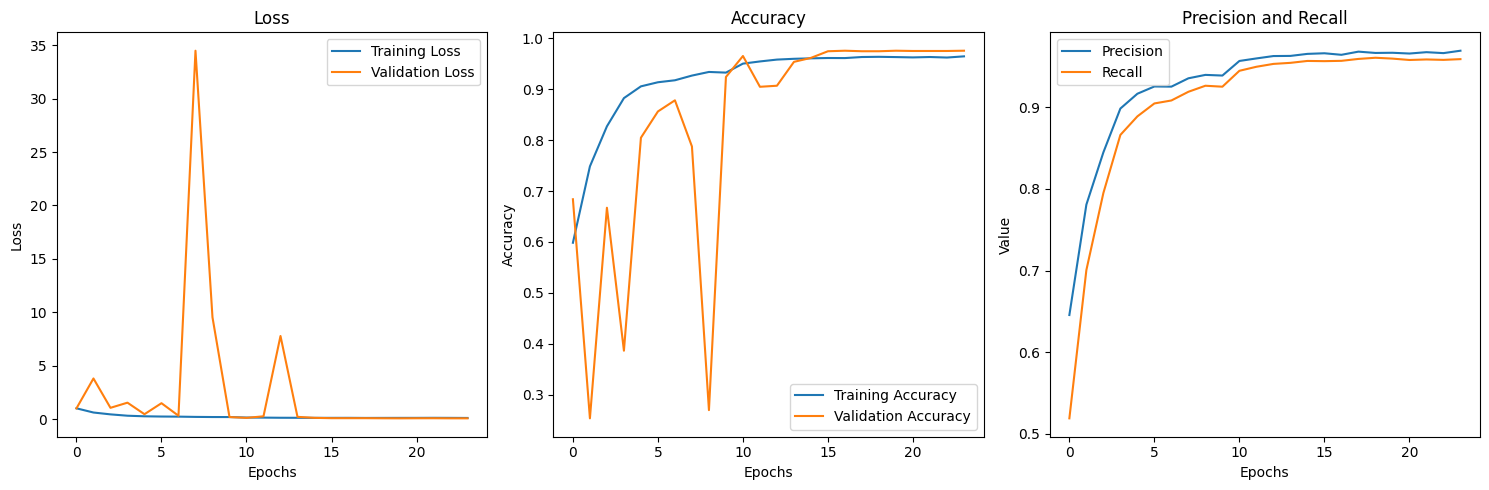

In [18]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    precision = history.history["precision"]
    recall = history.history["recall"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label="Training Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot precision and recall
    plt.subplot(1, 3, 3)
    plt.plot(epochs, precision, label="Precision")
    plt.plot(epochs, recall, label="Recall")
    plt.title("Precision and Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_curves function after training
plot_curves(VGG19_history)


In [19]:
VGG19_Predictions = VGG19_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
VGG19_Predictions = np.argmax(VGG19_Predictions, axis=1)

In [20]:
history = VGG19_history
final_accuracy = history.history['accuracy'][-1]
final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]
final_val_loss = history.history['val_loss'][-1]
final_f1_score = (2 * final_precision * final_recall) / (final_precision + final_recall)

print("*" * 8, "Final Metrics", "*" * 8)
print("Final Accuracy        : {:.2%}".format(final_accuracy))
print("Final Precision       : {:.2%}".format(final_precision))
print("Final Recall          : {:.2%}".format(final_recall))
print("Final Validation Loss : {:.4f}".format(final_val_loss))
print("Final F1 Score        : {:.3}".format(final_f1_score))

******** Final Metrics ********
Final Accuracy        : 96.44%
Final Precision       : 96.92%
Final Recall          : 95.89%
Final Validation Loss : 0.0831
Final F1 Score        : 0.964


Text(0.5, 1.0, 'VGG19 Confusion Matrix')

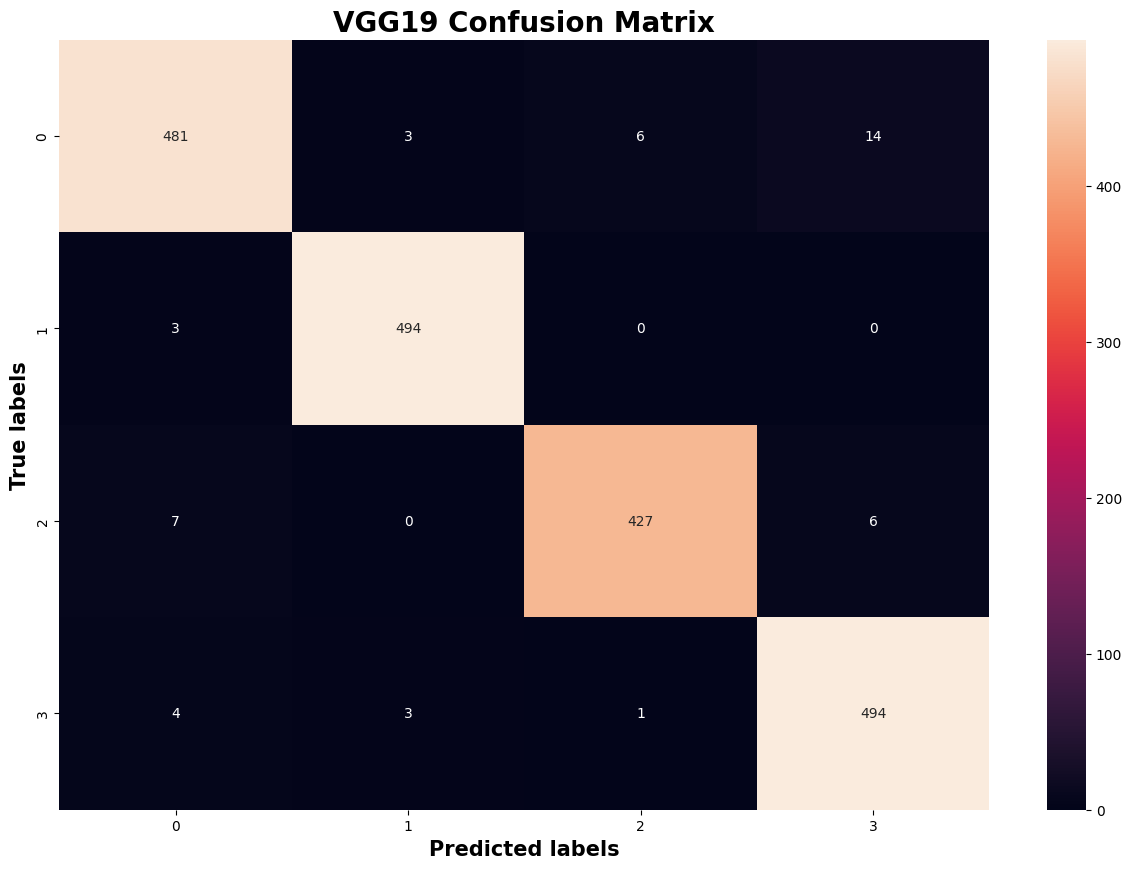

In [21]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, VGG19_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('VGG19 Confusion Matrix', fontsize=20, fontweight='bold')

# **Visualizing Predictions**

In [22]:
class_indices = test_data.class_indices
Condition_Classes = [key.capitalize() for key in class_indices.keys()]
print(Condition_Classes)

['Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Healthy']


In [23]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 1943 images belonging to 4 classes.


**VGG19 Predictions**

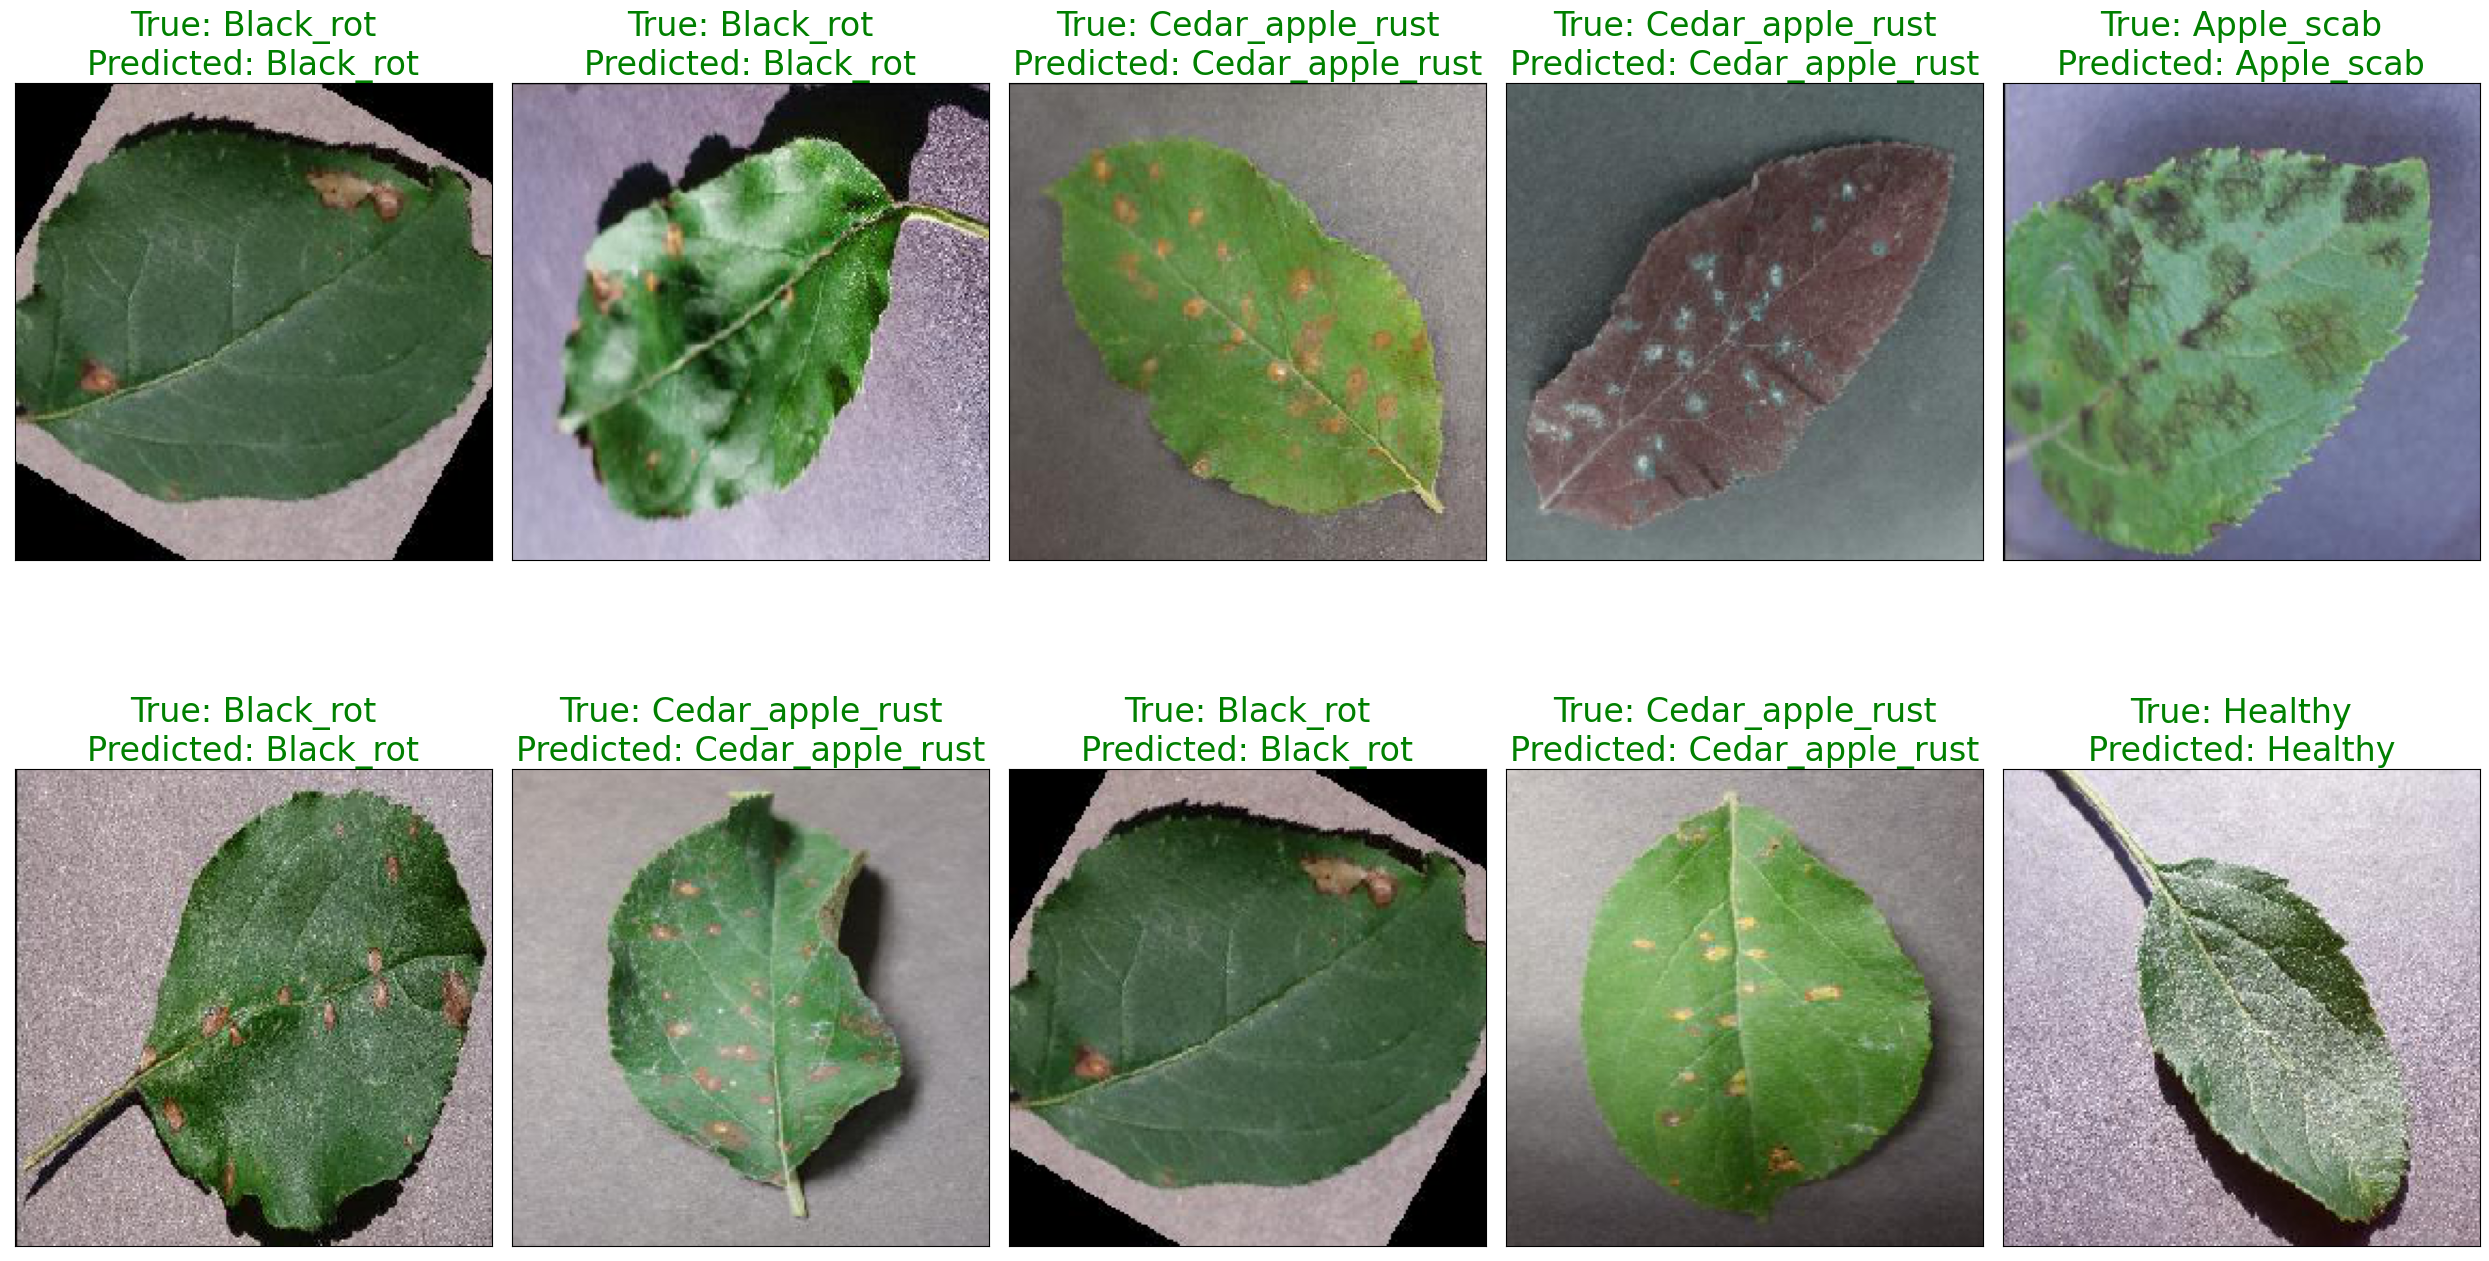

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Assuming test_generator contains your image data
# batch_size is the size of the batch
# Emotion_Classes is a list containing emotion classes

Random_batch = np.random.randint(0, len(test_generator) - 1)
Random_Img_Index = np.random.randint(0, batch_size - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 15),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_resized = resize(Random_Img, (224, 224), anti_aliasing=True)

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Prediction = np.argmax(VGG19_Model.predict(Random_Img_resized.reshape(1, 224, 224, 3), verbose=0))

    ax.imshow(Random_Img_resized)

    if Condition_Classes[Random_Img_Label] == Condition_Classes[Model_Prediction]:
        color = "green"
    else:
        color = "red"
        
    ax.set_title(f"True: {Condition_Classes[Random_Img_Label]}\nPredicted: {Condition_Classes[Model_Prediction]}", color=color, fontsize=24)

plt.tight_layout()
plt.show()


# **Predicting New Images**

In [25]:
import cv2
import matplotlib.pyplot as plt

def load_and_prep_image(filename, img_shape = 224):

    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.imshow(img)

    
    RGBImg= cv2.resize(img,(img_shape,img_shape))

    RGBImg = RGBImg/255.

    return RGBImg

In [26]:
def pred_and_plot(filename, class_names, size):

    # Import the target image and preprocess it
    Random_Img = load_and_prep_image(filename, size)

    # Make a prediction
    Model_Prediction = np.argmax(VGG19_Model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))
    pred_class = class_names[Model_Prediction]
    print("Condition Identified as: ", pred_class)
   
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    plt.show()


Condition Identified as:  Cedar_apple_rust


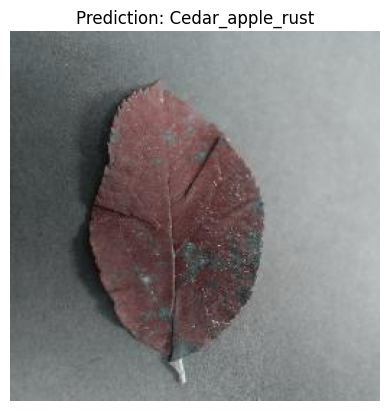

In [27]:
pred_and_plot("../input/apple-disease-dataset/datasets/test/cedar_apple_rust/69ceb6f0-6e63-4676-90a6-288ae97b0c2f___FREC_C.Rust 0107_newGRR.JPG", Condition_Classes, 224)

Condition Identified as:  Healthy


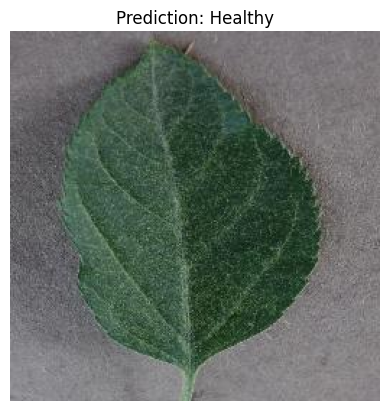

In [28]:
pred_and_plot("../input/apple-disease-dataset/datasets/test/healthy/0c55b379-c6e7-4b89-959f-abc506fed437___RS_HL 5927.JPG", Condition_Classes, 224)

In [29]:
VGG19_Model.save("Apple_VGG19_Model.h5")

# **Detcting Apple Scab Image**
#### The Image is Not Inculded in Dataset

In [30]:
!wget https://ohioline.osu.edu/sites/ohioline/files/imce/Plant_Pathology/PLPATH-FRU-23-scab-apple-figure-1.png

--2024-05-08 17:50:02--  https://ohioline.osu.edu/sites/ohioline/files/imce/Plant_Pathology/PLPATH-FRU-23-scab-apple-figure-1.png
Resolving ohioline.osu.edu (ohioline.osu.edu)... 3.134.15.214, 3.17.113.112, 3.132.156.251, ...
Connecting to ohioline.osu.edu (ohioline.osu.edu)|3.134.15.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320744 (313K) [image/png]
Saving to: ‘PLPATH-FRU-23-scab-apple-figure-1.png’

PLPATH-FRU-23-scab- 100%[===================>] 313.23K  --.-KB/s    in 0.08s   

2024-05-08 17:50:03 (3.63 MB/s) - ‘PLPATH-FRU-23-scab-apple-figure-1.png’ saved [320744/320744]



Condition Identified as:  Apple_scab


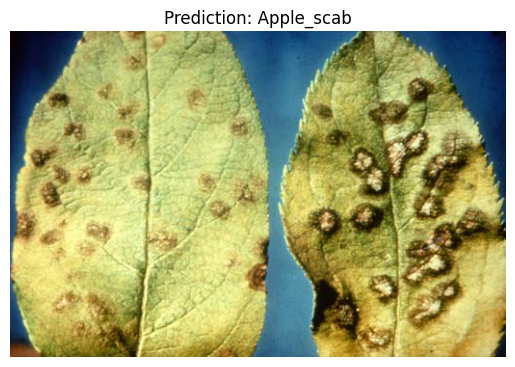

In [31]:
pred_and_plot("/kaggle/working/PLPATH-FRU-23-scab-apple-figure-1.png", Condition_Classes, 224)